In [1]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import (find_optimal_svd_rank,
                                         find_optimal_config,
                                         set_config)

from scaledsvd import ScaledSVD, ScaledSVDItemColdStart
from data_preprocessing import (get_movielens_data,
                                get_bookcrossing_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [27]:
from polara.recommender import defaults
defaults.memory_hard_limit = 3 # allowed memory usage during recommendations generation

In [3]:
seed = 42

In [4]:
experiment_name = 'scaledsvd'

# Experiment setup

In [5]:
data_labels = ['ML1M', 'ML10M', 'BX']

In [6]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'ML1M': [r for r in ranks_grid if r <= 1000],
             'ML10M': [r for r in ranks_grid if r <= 1000],
             'BX': [r for r in ranks_grid if r <= 2000]}

In [7]:
scaling_params = [0.2, 0.4, 0.6]

In [8]:
topk_values = [1, 3, 10, 20, 30]

In [9]:
target_metric = 'mrr'

In [10]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [11]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Movielens1M

In [12]:
lbl = 'ML1M'

In [15]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('C:/Users/evfro/Downloads/ml-1m.zip',
                                                    meta_path='data/meta_info_ml1m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [16]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [17]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Movielens10M

In [18]:
lbl = 'ML10M'

In [19]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('C:/Users/evfro/Downloads/ml-10m.zip',
                                                    meta_path='data/meta_info_ml10m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [20]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [21]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## BookCrossing

In [22]:
lbl = 'BX'

In [23]:
data_dict[lbl], meta_dict[lbl] = get_bookcrossing_data('C:/Users/evfro/Downloads/BX-CSV-Dump.zip',
                                                       get_books_meta=True,
                                                       implicit=True,
                                                       pcore=5,
                                                       filter_no_meta=True)

In [24]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [25]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [26]:
print_data_stats(data_labels, all_data)

ML1M
{'userid': 6038, 'movieid': 3522}
density 2.699052132255699
similarity matrix density 51.672185638677114
ML10M
{'userid': 69797, 'movieid': 10258}
density 0.6991397242349022
similarity matrix density 51.91219966091452
BX
{'userid': 7160, 'isbn': 16273}
density 0.18925598044812894
similarity matrix density 0.4827469267285518


# Standard experiment

In [28]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [ScaledSVD(data_model)]
    apply_config(models, config, data_label)
    return models

def fine_tune_scaledsvd(model, ranks, scale_params, label, record_time=False):
    param_grid = [(s, r) for s in scale_params for r in reversed(list(sorted(ranks)))]
    param_names = ('col_scaling', 'rank')
    best_svd_config, svd_scores = find_optimal_config(model, param_grid, param_names,
                                                      target_metric,
                                                      return_scores=True,
                                                      force_build=False,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_svd_config))}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, svd_scores.xs(max_rank, level='rank').index, label)
    finally:
        return model_config, model_scores

## tuning

In [29]:
config = {}
scores = {}
data_models = {}

In [30]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_scaledsvd(ScaledSVD(data_models[label]),
                                                       svd_ranks[label],
                                                       scaling_params,
                                                       label, record_time=True)

 [████████████████████████████████████████████████████████████] 3/3 [28:29<12:20, 569.59s/it]

           ML1M [█████████████████████████████████████████████] 60/60 [02:01<00:00, 2.01s/it]

          ML10M [█████████████████████████████████████████████] 60/60 [13:58<00:03, 13.97s/it]

             BX [█████████████████████████████████████████████] 72/72 [12:19<00:00, 10.26s/it]

C:\Users\evfro\Anaconda\envs\lab\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


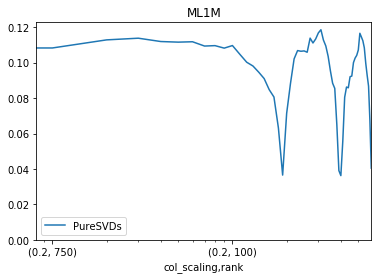

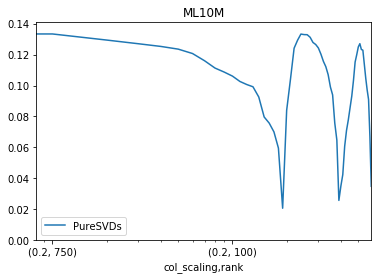

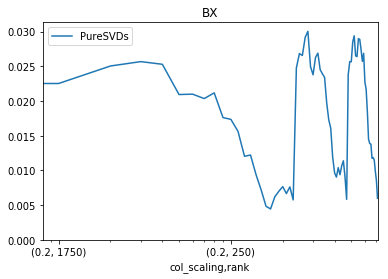

In [31]:
report_results('rank', scores);

In [32]:
config

{'ML1M': {'PureSVDs': {'col_scaling': 0.4, 'rank': 75}},
 'ML10M': {'PureSVDs': {'col_scaling': 0.2, 'rank': 1000}},
 'BX': {'PureSVDs': {'col_scaling': 0.4, 'rank': 1000}}}

### saving data

In [33]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [34]:
result = {}

for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=f'{label} folds'))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 3/3 [22:04<06:13, 441.47s/it]

     ML1M folds [█████████████████████████████████████████████] 5/5 [00:08<00:02, 1.56s/it]

    ML10M folds [█████████████████████████████████████████████] 5/5 [15:44<03:13, 188.76s/it]

       BX folds [█████████████████████████████████████████████] 5/5 [06:13<01:14, 74.55s/it]

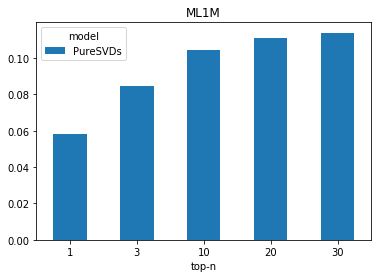

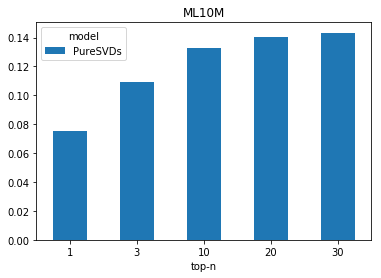

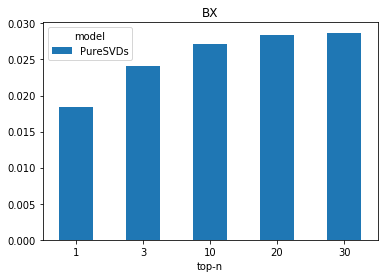

In [35]:
report_results('topn', result, target_metric);

### saving data

In [36]:
save_results(experiment_name, cv=result)

# Cold start

In [37]:
import gc
gc.collect()

7580

In [38]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [ScaledSVDItemColdStart(data_model, item_features=meta_dict[data_label])]
    apply_config(models, config, data_label)
    return models

## tuning

In [39]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [40]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = ScaledSVDItemColdStart(data_models_cold[label],
                                   item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_scaledsvd(model,
                                                                 svd_ranks[label],
                                                                 scaling_params,
                                                                 label, record_time=False)

 [████████████████████████████████████████████████████████████] 3/3 [26:17<12:17, 525.55s/it]

           ML1M [█████████████████████████████████████████████] 60/60 [02:00<00:00, 2.00s/it]

          ML10M [█████████████████████████████████████████████] 60/60 [11:54<00:02, 11.90s/it]

             BX [█████████████████████████████████████████████] 72/72 [12:16<00:01, 10.22s/it]

C:\Users\evfro\Anaconda\envs\lab\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


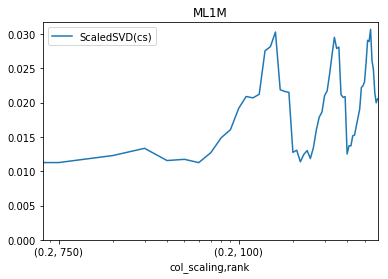

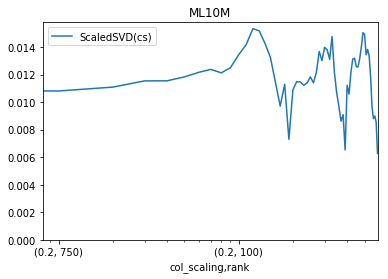

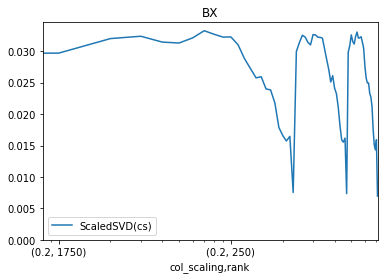

In [41]:
report_results('rank', scores_cold);

In [42]:
config_cold

{'ML1M': {'ScaledSVD(cs)': {'col_scaling': 0.6, 'rank': 30}},
 'ML10M': {'ScaledSVD(cs)': {'col_scaling': 0.2, 'rank': 60}},
 'BX': {'ScaledSVD(cs)': {'col_scaling': 0.2, 'rank': 400}}}

### saving data

In [43]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [44]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 3/3 [02:06<01:10, 41.91s/it]

     ML1M folds [█████████████████████████████████████████████] 5/5 [00:05<00:01, 0.95s/it]

    ML10M folds [█████████████████████████████████████████████] 5/5 [00:51<00:11, 10.28s/it]

       BX folds [█████████████████████████████████████████████] 5/5 [01:10<00:14, 13.91s/it]

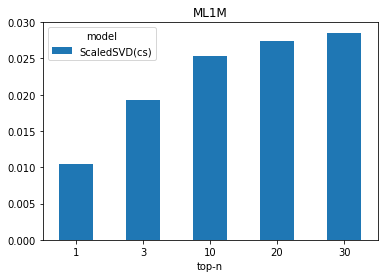

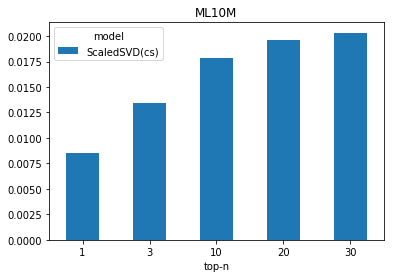

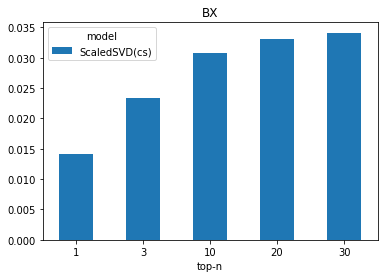

In [45]:
report_results('topn', result_cold, target_metric);

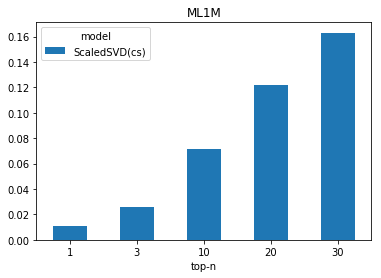

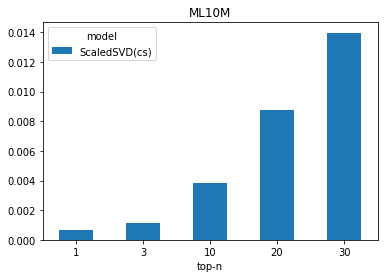

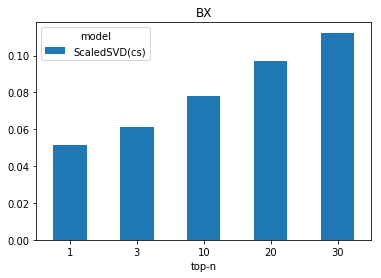

In [46]:
report_results('topn', result_cold, 'coverage');

### saving data

In [47]:
save_results(experiment_name+'_coldstart', cv=result_cold)